In [68]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uk-housing-prices-paid/price_paid_records.csv


# House Price Analysis- England & Wales


## Objectives:

- Investigate overall trends for house prices in England and Wales over a 10 year period, 2006-2016.

- Identify property hotspots from this period (areas with the greatest increase in price.

## About The Data:

The data used is a csv file from Kaggle, the data is sourced from HM Land Registry and was released under Open Government License 3.0. This is a large dataset, containing Price Paid data for England and Wales between 1995 and 2017.

## Inspecting the Data

In [69]:
#import packages and data
import pandas as pd
df = pd.read_csv(r'/kaggle/input/uk-housing-prices-paid/price_paid_records.csv')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='deep')
import numpy as np
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
#see all column names
pd.set_option('display.max_columns', None)
#get rid of an error message
pd.set_option('mode.use_inf_as_na', True)

/tmp/ipykernel_100/3116726316.py:13: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


In [70]:
#check the head of the df
df.head()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18 00:00,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09 00:00,S,N,F,GRAYS,THURROCK,THURROCK,A,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30 00:00,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24 00:00,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23 00:00,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A


In [71]:
#check the size of the df (rows, columns)
df.shape

(22489348, 11)

In [72]:
#check the column names to see if all are relevant to this analysis
df.columns

Index(['Transaction unique identifier', 'Price', 'Date of Transfer',
       'Property Type', 'Old/New', 'Duration', 'Town/City', 'District',
       'County', 'PPDCategory Type', 'Record Status - monthly file only'],
      dtype='object')

In [73]:
#Check the sum of NaN entries in each column, the dataset is complete, thanks HMLR
df.isna().sum()

Transaction unique identifier        0
Price                                0
Date of Transfer                     0
Property Type                        0
Old/New                              0
Duration                             0
Town/City                            0
District                             0
County                               0
PPDCategory Type                     0
Record Status - monthly file only    0
dtype: int64

In [74]:
#Check for any duplicate rows, TUI is a good column to indicate this
df['Transaction unique identifier'].duplicated().any()

False

In [75]:
#Check data types by column, it would be useful if 'Date of Transfer' was in pandas datetime format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 11 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   Transaction unique identifier      object
 1   Price                              int64 
 2   Date of Transfer                   object
 3   Property Type                      object
 4   Old/New                            object
 5   Duration                           object
 6   Town/City                          object
 7   District                           object
 8   County                             object
 9   PPDCategory Type                   object
 10  Record Status - monthly file only  object
dtypes: int64(1), object(10)
memory usage: 1.8+ GB


# Data Cleansing


In [76]:
#Make a copy to keep the original df intact in case it is required later on
df1=df.copy()

In [77]:
#Drop property type 0, this is like a misc type of property and is likely to contain outliers which could skew, also dropping Flats/Maisonettes as the brief is to investigate house prices, not overall property prices

df1 = df1[df1['Property Type'] != 'O']
df1 = df1[df1['Property Type'] != 'F']

#Drop columns 1, 3, 4, 5, 9 and 10 as they are not relevant this time
columns_to_drop= ['Transaction unique identifier','Property Type', 'District', 'Old/New',  'Duration', 'PPDCategory Type', 'Record Status - monthly file only']
df1=df1.drop(columns=columns_to_drop)

In [78]:
#Convert the date of transfer column to a pandas datetime type for easier'
df1['Date of Transfer'] = pd.to_datetime(df1['Date of Transfer'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18305356 entries, 0 to 22489347
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Price             int64         
 1   Date of Transfer  datetime64[ns]
 2   Town/City         object        
 3   County            object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 698.3+ MB


In [79]:
#Create a numerical column for year of transfer
df1['Year of Transfer'] = pd.to_datetime(df1['Date of Transfer']).dt.year

In [80]:
#Remove all values from outside of the time period required, 2006-2016, also resetting the index on this slice of data
df1 = df1[(df1['Year of Transfer'] >= 2006) & (df1['Year of Transfer'] <= 2016)]
df1 = df1.reset_index(drop=True)
df1.head()

,Price,Date of Transfer,Town/City,County,Year of Transfer
0,249950,2006-01-27,NOTTINGHAM,NOTTINGHAMSHIRE,2006
1,150000,2006-08-02,SOUTHAM,WARWICKSHIRE,2006
2,124000,2006-06-09,NOTTINGHAM,NOTTINGHAMSHIRE,2006
3,118000,2006-12-08,CARDIFF,CARDIFF,2006
4,119950,2006-07-31,MANCHESTER,GREATER MANCHESTER,2006


# House Prices: Overall Trends

Visualisations that show the overall trends for house prices in England & Wales between 2006 and 2016. I aim to make these as cleara and accessible as possible.

In [81]:
# Group the data by year and find the average price for the year
av_price = df1.groupby('Year of Transfer')['Price'].mean().reset_index()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


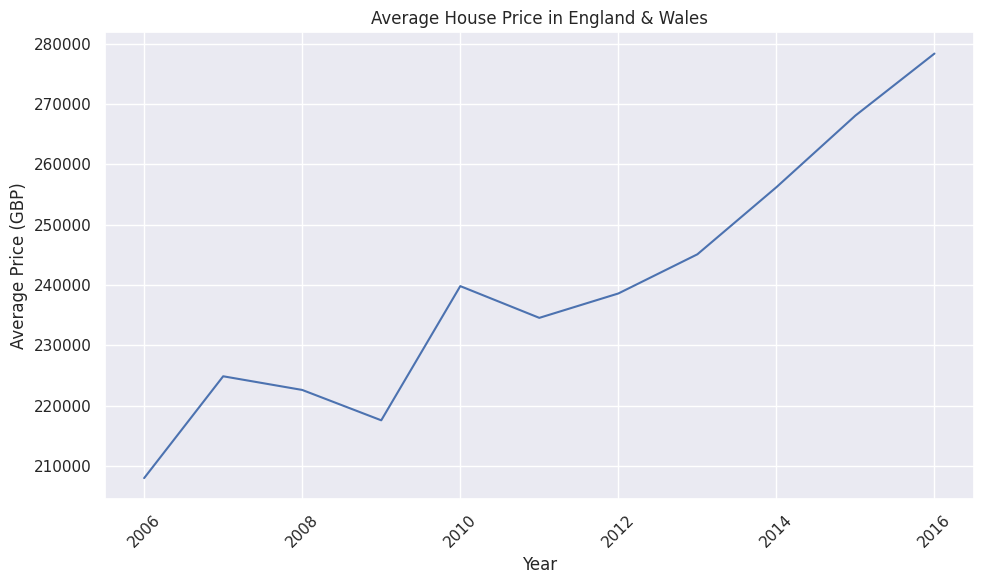

In [82]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=av_price, x='Year of Transfer', y='Price')
plt.title('Average House Price in England & Wales')
plt.xlabel('Year')
plt.ylabel('Average Price (GBP)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

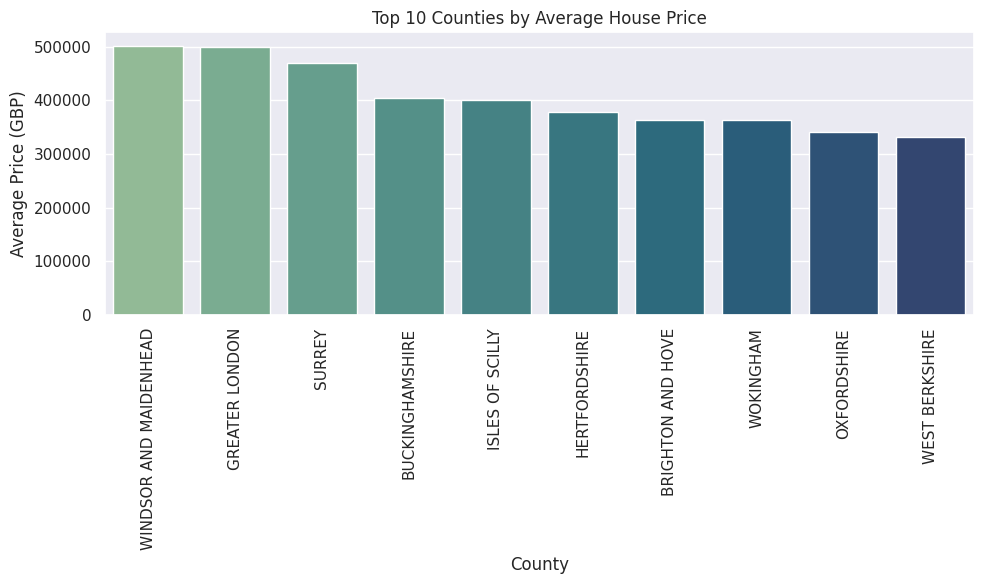

In [83]:
#Group the data by county, find the average price for each county
av_price_bycounty = df1.groupby('County')['Price'].mean().reset_index()
#Sort by descending
av_price_bycounty = av_price_bycounty.sort_values(by='Price', ascending=False)
#I will recall N as the number to be shown on the graph in both highest and lowest graphs
N = 10
top_counties = av_price_bycounty.nlargest(N, 'Price')

# Plot the average house price by county
plt.figure(figsize=(10, 6))
sns.barplot(data=top_counties, x='County', y='Price', palette='crest')

plt.title('Top 10 Counties by Average House Price')

plt.xlabel('County')
plt.ylabel('Average Price (GBP)')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

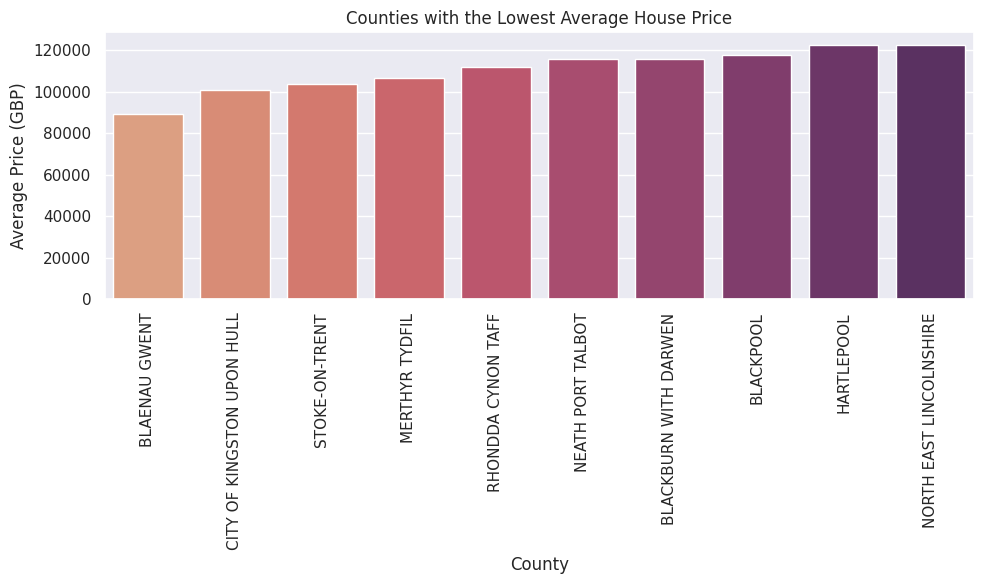

In [84]:
low_counties = av_price_bycounty.nsmallest(N, 'Price')

plt.figure(figsize=(10, 6))
sns.barplot(data=low_counties, x='County', y='Price', palette='flare')

plt.title('Counties with the Lowest Average House Price')

plt.xlabel('County')
plt.ylabel('Average Price (GBP)')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


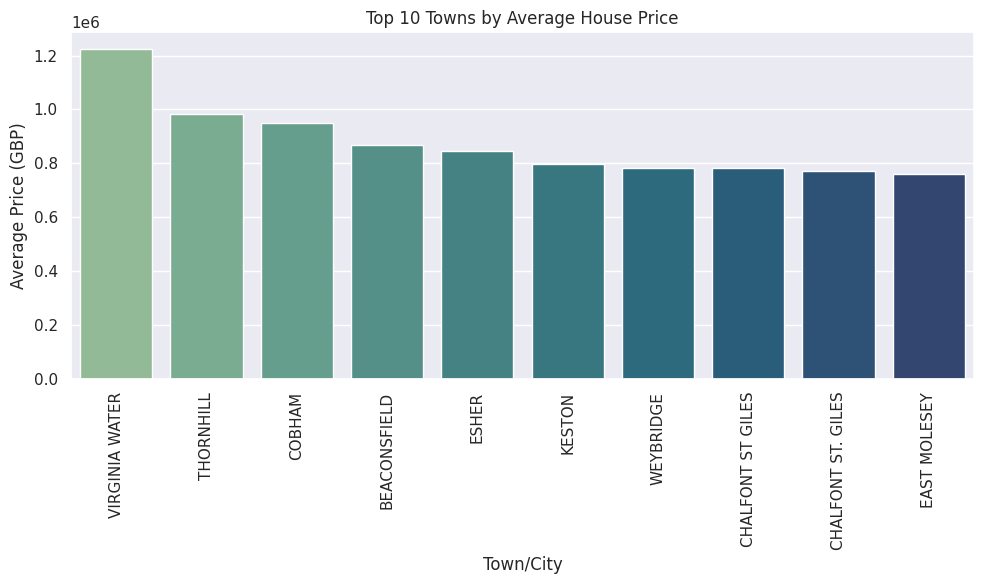

In [85]:
#Group the data by town/city, find the average price for each county
av_price_bytown = df1.groupby('Town/City')['Price'].mean().reset_index()
#Sort by descending
av_price_bytown = av_price_bytown.sort_values(by='Price', ascending=False)
#I will recall N as the number to be shown on the graph in both highest and lowest graphs
N = 10
top_towns = av_price_bytown.nlargest(N, 'Price')

# Plot the average house price by county
plt.figure(figsize=(10, 6))
sns.barplot(data=top_towns, x='Town/City', y='Price', palette='crest')

plt.title('Top 10 Towns by Average House Price')

plt.xlabel('Town/City')
plt.ylabel('Average Price (GBP)')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

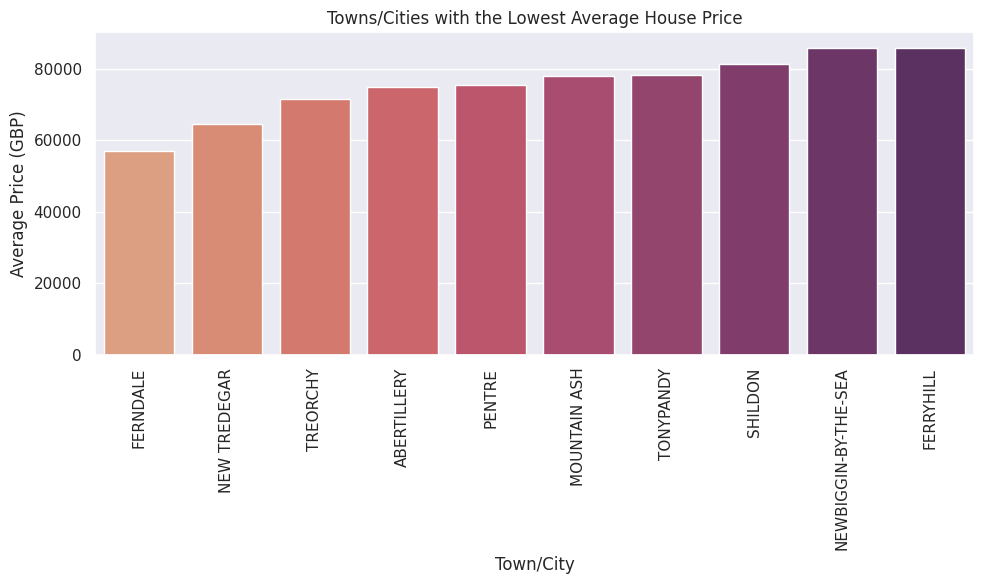

In [86]:
low_towns = av_price_bytown.nsmallest(N, 'Price')

plt.figure(figsize=(10, 6))
sns.barplot(data=low_towns, x='Town/City', y='Price', palette='flare')

plt.title('Towns/Cities with the Lowest Average House Price')

plt.xlabel('Town/City')
plt.ylabel('Average Price (GBP)')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Identifying Property Hotspots

Property hotspots for the purpose of this analysis are areas which have had the greatest increase in value over the timeframe.

In [92]:
#Sorting the df by town and year
df1.sort_values(by=['Town/City', 'Year of Transfer'], inplace=True)
#Add a new column for price increase based on the percentage change of price over time for each town/city
df1['Price Increase'] = df1.groupby('Town/City')['Price'].pct_change()
df1.head()

,Price,Date of Transfer,Town/City,County,Year of Transfer,Price Increase
4657,232500,2006-08-01,ABBOTS LANGLEY,HERTFORDSHIRE,2006,NaN
12784,164500,2006-04-07,ABBOTS LANGLEY,HERTFORDSHIRE,2006,-0.292473
13115,225000,2006-08-10,ABBOTS LANGLEY,HERTFORDSHIRE,2006,0.367781
13920,296000,2006-09-22,ABBOTS LANGLEY,HERTFORDSHIRE,2006,0.315556
20498,365000,2006-05-08,ABBOTS LANGLEY,HERTFORDSHIRE,2006,0.233108
